# install or import libraries 

In [ ]:
!pip install pyod

In [29]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import random
from sklearn.datasets import make_spd_matrix;
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
import copy

# algorithms
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lof import LOF
from pyod.models.iforest import IForest

# evaluation
from sklearn.model_selection import train_test_split;
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

Common Function

In [30]:
def train_test_eval( y_train, y_test,y_train_pred,y_test_pred ):
  tr_prec = precision_score(y_train, y_train_pred, average='weighted')
  tr_rec = recall_score(y_train, y_train_pred, average='weighted')
  tr_acc = accuracy_score(y_train, y_train_pred, normalize=True);
  tr_f1 = f1_score(y_train, y_train_pred, average='weighted')

  tst_prec = precision_score(y_test, y_test_pred, average='weighted')
  tst_rec = recall_score(y_test, y_test_pred, average='weighted')
  tst_acc = accuracy_score(y_test, y_test_pred, normalize=True);
  tst_f1 = f1_score(y_test, y_test_pred, average='weighted')

  return tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1

In [31]:
#@jit(target_backend='cuda') 
def apply_anomaly_detection(x_train ,  x_test , clf):
  clf.fit(x_train.values)
  y_train_pred = clf.predict(x_train.values)
  y_test_pred = clf.predict(x_test.values) 
  #print('a')
  return y_train_pred,y_test_pred

In [32]:
def mu_vector( n_features, low_range, high_range):
    """
    This function is used to generate the mean vector for various
    Gaussians in GMM
    """
    #print("mu_vector")
    mu_set = set()
    while(len(mu_set) < n_features):
      mu_set.add(random.randint(low_range, high_range))
    #mu_vector_lst.append(mu_set)
    return list(mu_set);

In [33]:
def split_data(df):
  X = df.loc[:, df.columns != "Label"]
  y= df["Label"]
  x_train , x_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.30)
  return x_train , x_test, y_train, y_test

In [264]:
cont_factor = np.arange(0.02,0.12,0.02)

In [265]:
cont_factor

array([0.02, 0.04, 0.06, 0.08, 0.1 ])

In [36]:
col_list =[]
met = ['Pr', 'Re', 'Ac', 'F1']
for j in met:
  col_list.append("Tr_"+j)
  col_list.append("Te_"+j)
col_list

['Tr_Pr', 'Te_Pr', 'Tr_Re', 'Te_Re', 'Tr_Ac', 'Te_Ac', 'Tr_F1', 'Te_F1']

# Multivariate normal

In [37]:
def generate_multivariate_gaussian_data( mu_vector, cov_m, n_features, num_datapoints, outlier):

  mu =  mu_vector; 
  cov_m = cov_m;
  # pass to mvn data generator
  mvn_rvs = multivariate_normal.rvs(mean=mu, cov=cov_m, size=num_datapoints, random_state=None);
  col_list =[]
  for i in range(n_features):
    col_nm = 'X_'+ str(i);
    col_list.append(col_nm);
  df = pd.DataFrame(mvn_rvs, columns=col_list );

  if(outlier == True):
    df['Label'] = 1
  else:
    df['Label'] = 0

  return df


# Multivariate uniform

In [38]:
def generate_multivariate_normal_data(llim, ulim, n_features,num_datapoints, outlier):
  mvu_rvs = np.random.uniform(llim, ulim, size= (num_datapoints, n_features));
  col_list =[]
  for i in range(n_features):
    col_nm = 'X_'+ str(i);
    col_list.append(col_nm);
  df = pd.DataFrame(mvu_rvs, columns=col_list );

  if(outlier == True):
    df['Label'] = 1
  else:
    df['Label'] = 0

  return df



# 1. Multivariate normal (inlier)+ Multivariate uniform (outlier)

In [183]:
df_names_list = ['DF_002', 'DF_004', 'DF_006', 'DF_008', 'DF_010' ]

In [86]:
dict_df = {}

In [214]:
lst = []

In [215]:
len(lst)

0

In [250]:
for j in range(3):
    print("j ",j)
    num_points = 10000;
    num_outlier = int( 0.10 *num_points);
    #print("num_outlier: ", num_outlier)

    num_inlier = (num_points - num_outlier);
    #print("num_inlier: ", num_inlier)


    n_features = random.randint(2, 10);
    #print("n_features",n_features)

    mu_low = random.randint(2, 20);
    mu_high = random.randint(20, 40);
    mu = mu_vector(n_features, mu_low, mu_high)
    # find covariance matrix
    cov_m = make_spd_matrix(n_features);
    df_inlier = generate_multivariate_gaussian_data(mu, cov_m,n_features, num_inlier, False);
    #print(df_inlier)
    llim = random.randint(2, 10);
    ulim = random.randint(15, 30);
    df_outlier = generate_multivariate_normal_data(llim, ulim, n_features,num_outlier, True);

    df = pd.concat([ df_outlier , df_inlier]);
    in_dst = df.loc[df['Label'] == 0]
    out_dst = df.loc[df['Label'] == 1]
    print("Inlier percent", len(in_dst)/len(df))
    print("Outlier percent", len(out_dst)/len(df))
    print("///////////////////////////////")

    lst.append(df);

    


j  0
Inlier percent 0.9
Outlier percent 0.1
///////////////////////////////
j  1
Inlier percent 0.9
Outlier percent 0.1
///////////////////////////////
j  2
Inlier percent 0.9
Outlier percent 0.1
///////////////////////////////


In [251]:
len(lst)

100

In [252]:
#key = df_names_list[i];
#print(len(lst))
dict_df['DF_010'] = lst

In [253]:
len(dict_df['DF_010'])

100

In [ ]:
# generate datasets 
for i in range(len(cont_factor)):
  print(i)
  cont = cont_factor[i];
  lst = []
  for j in range(100):
    print("i , j",i,j)
    num_points = 10000;
    num_outlier = int( cont *num_points);
    #print("num_outlier: ", num_outlier)

    num_inlier = (num_points - num_outlier);
    #print("num_inlier: ", num_inlier)


    n_features = random.randint(2, 10);
    #print("n_features",n_features)

    mu_low = random.randint(2, 20);
    mu_high = random.randint(20, 40);
    mu = mu_vector(n_features, mu_low, mu_high)
    # find covariance matrix
    cov_m = make_spd_matrix(n_features);
    df_inlier = generate_multivariate_gaussian_data(mu, cov_m,n_features, num_inlier, False);
    #print(df_inlier)
    llim = random.randint(2, 10);
    ulim = random.randint(15, 30);
    df_outlier = generate_multivariate_normal_data(llim, ulim, n_features,num_outlier, True);

    df = pd.concat([ df_outlier , df_inlier]);
    #in_dst = df.loc[df['Label'] == 0]
    #out_dst = df.loc[df['Label'] == 1]
    #print("Inlier percent", len(in_dst)/len(df))
    #print("Outlier percent", len(out_dst)/len(df))
    #print("///////////////////////////////")

    lst.append(df);

    
  #key = df_names_list[i];
  #print(len(lst))
  #dict_df[key] = lst
  

    #print(df)
  #print(lst[0])


In [74]:
len(dict_df['DF_010']) 

2

In [70]:
len(dict_df['DF_010'])

2

###

In [258]:
for key in dict_df.keys():
  print(len(dict_df[key]))

100
100
100
100
100


### 1.1 OCSVM

In [266]:
dict_eval = {}

In [267]:
for i in range(len(cont_factor)):
  clf = OCSVM(contamination = cont_factor[i]);
  key = df_names_list[i]
  df = copy.deepcopy(dict_df[key])
  lst_name = []
  print(i)
  for j in df:
    #print("i & j ", i,j)
    temp_lst = []
    #X = norm.rvs(loc=mu, scale=std,size=10000);
    #df = label_gaussian_outliers_new( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
       
    
    lst_name.append(temp_lst)

  df_name = "Eval_OCSVM_"+str(round(i,3))
  dict_eval[df_name]= pd.DataFrame(lst_name, columns=col_list)


0
1
2
3
4


In [268]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
ocsvm_cont_results_mean = pd.DataFrame(columns = mu_result_cols) 
ocsvm_cont_results_mean['cont_fact'] = cont_factor;                           
lst_mu = []

In [269]:

for val in dict_eval.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    
ocsvm_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [270]:
ocsvm_cont_results_mean

,cont_fact,Train_Pr_mu,Test_Pr_mu,Train_Re_mu,Test_Re_mu,Train_Acc_mu,Test_Acc_mu,Train_F1_mu,Test_F1_mu
0,0.02,0.999586,0.999418,0.999586,0.999403,0.999586,0.999403,0.999586,0.999407
1,0.04,0.999446,0.999279,0.999446,0.999267,0.999446,0.999267,0.999446,0.999271
2,0.06,0.998763,0.998663,0.998763,0.998650,0.998763,0.998650,0.998763,0.998655
3,0.08,0.998809,0.998707,0.998809,0.998707,0.998809,0.998707,0.998809,0.998706
4,0.10,0.999011,0.998874,0.999011,0.998877,0.999011,0.998877,0.999011,0.998874


In [271]:
ocsvm_cont_results_mean.to_excel("MVN_I_MVU_O_OCSVM_CF_Mean.xlsx");

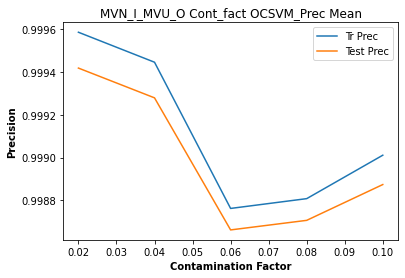

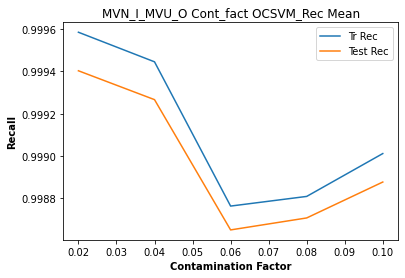

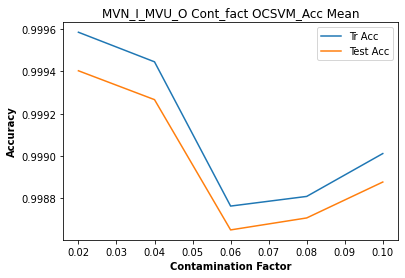

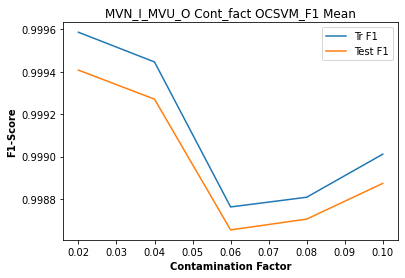

In [272]:
plt.title("MVN_I_MVU_O Cont_fact OCSVM_Prec Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'], ocsvm_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('MVN_I_MVU_O_OCSVM_CF_Mean_Prec.png', bbox_inches='tight')   
plt.show()

plt.title("MVN_I_MVU_O Cont_fact OCSVM_Rec Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('MVN_I_MVU_O_OCSVM_CF_Mean_Rec.png', bbox_inches='tight')
plt.show()


plt.title("MVN_I_MVU_O Cont_fact OCSVM_Acc Mean")
plt.plot( ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('MVN_I_MVU_O_OCSVM_CF_Mean_Acc.png', bbox_inches='tight')
plt.show()


plt.title("MVN_I_MVU_O Cont_fact OCSVM_F1 Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('MVN_I_MVU_O_OCSVM_CF_Mean_F1.png', bbox_inches='tight')
plt.show()

### 1.2 LOF

In [273]:
dict_eval = {}

In [274]:
for i in range(len(cont_factor)):
  clf = LOF(contamination = cont_factor[i]);
  key = df_names_list[i]
  df = copy.deepcopy(dict_df[key])
  lst_name = []
  print(i)
  for j in df:
    #print("i & j ", i,j)
    temp_lst = []
    #X = norm.rvs(loc=mu, scale=std,size=10000);
    #df = label_gaussian_outliers_new( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    lst_name.append(temp_lst)

  df_name = "Eval_LOF_"+str(round(i,3))
  dict_eval[df_name]= pd.DataFrame(lst_name, columns=col_list)


0
1
2
3
4


In [275]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
lof_cont_results_mean = pd.DataFrame(columns = mu_result_cols) 
lof_cont_results_mean['cont_fact'] = cont_factor;
lst_mu = []

In [276]:
for val in dict_eval.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    
lof_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [277]:
lof_cont_results_mean
lof_cont_results_mean.to_excel("MVN_I_MVU_O_LOF_CF.xlsx");

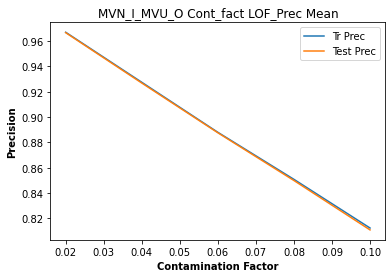

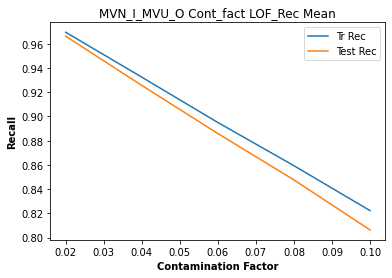

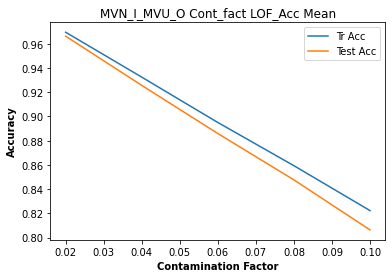

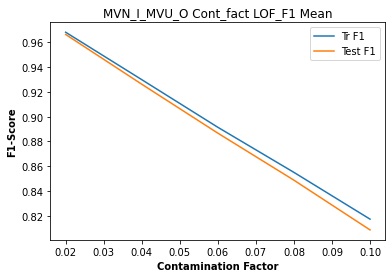

In [278]:
plt.title("MVN_I_MVU_O Cont_fact LOF_Prec Mean")
plt.plot(lof_cont_results_mean['cont_fact'], lof_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('MVN_I_MVU_O_LOF_CF_Mean_Prec.png', bbox_inches='tight')
plt.show()

plt.title("MVN_I_MVU_O Cont_fact LOF_Rec Mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('MVN_I_MVU_O_LOF_CF_Mean_Rec.png', bbox_inches='tight')
plt.show()


plt.title("MVN_I_MVU_O Cont_fact LOF_Acc Mean")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('MVN_I_MVU_O_LOF_CF_Mean_Acc.png', bbox_inches='tight')
plt.show()


plt.title("MVN_I_MVU_O Cont_fact LOF_F1 Mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('MVN_I_MVU_O_LOF_CF_Mean_F1.png', bbox_inches='tight')
plt.show()

### 1.3 PCA

In [279]:
dict_eval = {}

In [280]:
for i in range(len(cont_factor)):
  clf = PCA(contamination = cont_factor[i]);
  key = df_names_list[i]
  df = copy.deepcopy(dict_df[key])
  lst_name = []
  print(i)
  for j in df:
    #print("i & j ", i,j)
    temp_lst = []
    num_comp = int((len(j.columns)-1)/2);
    clf.n_components = num_comp;
    #X = norm.rvs(loc=mu, scale=std,size=10000);
    #df = label_gaussian_outliers_new( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    lst_name.append(temp_lst)

  df_name = "Eval_PCA_"+str(round(i,3))
  dict_eval[df_name]= pd.DataFrame(lst_name, columns=col_list)


0
1
2
3
4


In [281]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
pca_cont_results_mean = pd.DataFrame(columns = mu_result_cols) 
pca_cont_results_mean['cont_fact'] = cont_factor;
lst_mu = []

In [282]:
for val in dict_eval.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    
pca_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [283]:
pca_cont_results_mean
pca_cont_results_mean.to_excel("MVN_I_MVU_O_PCA_CF.xlsx");

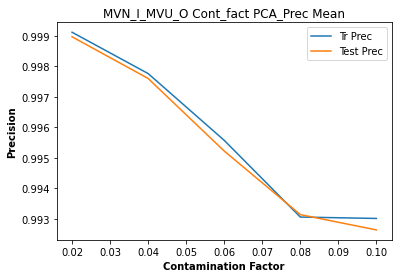

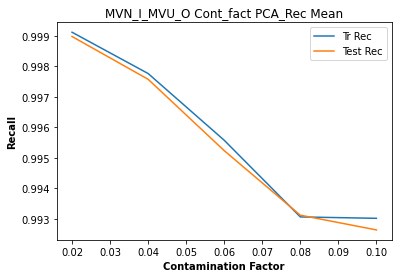

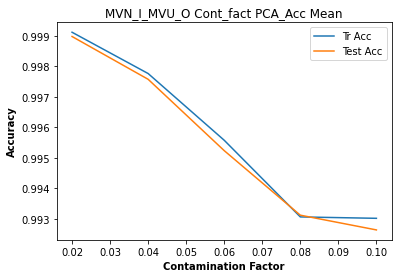

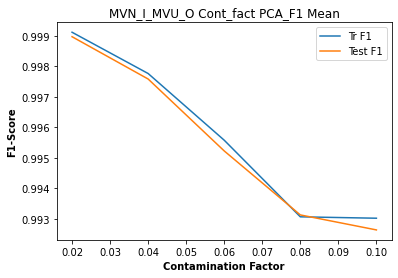

In [284]:
plt.title("MVN_I_MVU_O Cont_fact PCA_Prec Mean")
plt.plot(pca_cont_results_mean['cont_fact'], pca_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( pca_cont_results_mean['cont_fact'],pca_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('MVN_I_MVU_O_PCA_CF_Mean_PCA.png', bbox_inches='tight')
plt.show()

plt.title("MVN_I_MVU_O Cont_fact PCA_Rec Mean")
plt.plot(pca_cont_results_mean['cont_fact'],pca_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(pca_cont_results_mean['cont_fact'],pca_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('MVN_I_MVU_O_PCA_CF_Mean_Rec.png', bbox_inches='tight')
plt.show()


plt.title("MVN_I_MVU_O Cont_fact PCA_Acc Mean")
plt.plot( pca_cont_results_mean['cont_fact'],pca_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(pca_cont_results_mean['cont_fact'],pca_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('MVN_I_MVU_O_PCA_CF_Mean_Acc.png', bbox_inches='tight')
plt.show()


plt.title("MVN_I_MVU_O Cont_fact PCA_F1 Mean")
plt.plot(pca_cont_results_mean['cont_fact'],pca_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(pca_cont_results_mean['cont_fact'],pca_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('MVN_I_MVU_O_PCA_CF_Mean_F1.png', bbox_inches='tight')
plt.show()

### 1.4 IF

In [285]:
dict_eval = {}

In [286]:
for i in range(len(cont_factor)):
  clf = IForest(contamination = cont_factor[i], n_jobs = 100);
  key = df_names_list[i]
  df = copy.deepcopy(dict_df[key])
  lst_name = []
  print(i)
  for j in df:
    #print("i & j ", i,j)
    temp_lst = []
    num_comp = int((len(j.columns)-1)/2);
    clf.n_components = num_comp;
    #X = norm.rvs(loc=mu, scale=std,size=10000);
    #df = label_gaussian_outliers_new( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    lst_name.append(temp_lst)

  df_name = "Eval_IF_"+str(round(i,3))
  dict_eval[df_name]= pd.DataFrame(lst_name, columns=col_list)


0
1
2
3
4


In [287]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
if_cont_results_mean = pd.DataFrame(columns = mu_result_cols) 
if_cont_results_mean['cont_fact'] = cont_factor;
lst_mu = []

In [288]:
for val in dict_eval.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    
if_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [291]:
if_cont_results_mean

,cont_fact,Train_Pr_mu,Test_Pr_mu,Train_Re_mu,Test_Re_mu,Train_Acc_mu,Test_Acc_mu,Train_F1_mu,Test_F1_mu
0,0.02,0.999129,0.999030,0.999129,0.999013,0.999129,0.999013,0.999129,0.999016
1,0.04,0.998407,0.998241,0.998407,0.998243,0.998407,0.998243,0.998407,0.998240
2,0.06,0.997586,0.997566,0.997586,0.997553,0.997586,0.997553,0.997586,0.997556
3,0.08,0.996931,0.996881,0.996931,0.996870,0.996931,0.996870,0.996931,0.996872
4,0.10,0.996770,0.996885,0.996770,0.996883,0.996770,0.996883,0.996770,0.996880


In [289]:

if_cont_results_mean.to_excel("MVN_I_MVU_O_IF_CF.xlsx");

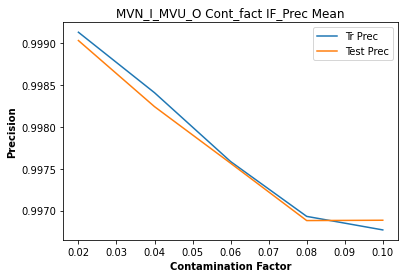

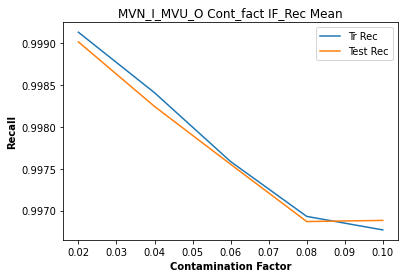

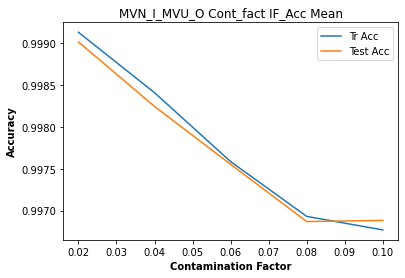

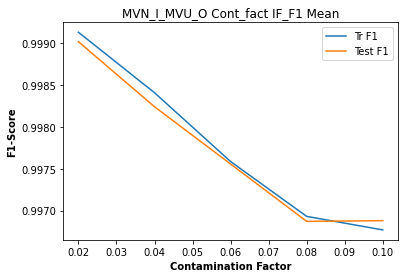

In [290]:
plt.title("MVN_I_MVU_O Cont_fact IF_Prec Mean")
plt.plot(if_cont_results_mean['cont_fact'], if_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( if_cont_results_mean['cont_fact'],if_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('MVN_I_MVU_O_IF_CF_Mean_Prec.png', bbox_inches='tight')
plt.show()

plt.title("MVN_I_MVU_O Cont_fact IF_Rec Mean")
plt.plot(if_cont_results_mean['cont_fact'],if_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(if_cont_results_mean['cont_fact'],if_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('MVN_I_MVU_O_IF_CF_Mean_Rec.png', bbox_inches='tight')
plt.show()


plt.title("MVN_I_MVU_O Cont_fact IF_Acc Mean")
plt.plot( if_cont_results_mean['cont_fact'],if_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(if_cont_results_mean['cont_fact'],if_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('MVN_I_MVU_O_IF_CF_Mean_Acc.png', bbox_inches='tight')
plt.show()


plt.title("MVN_I_MVU_O Cont_fact IF_F1 Mean")
plt.plot(if_cont_results_mean['cont_fact'],if_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(if_cont_results_mean['cont_fact'],if_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('MVN_I_MVU_O_IF_CF_Mean_F1.png', bbox_inches='tight')
plt.show()

#  2. Multivariate uniform (inlier)+ Multivariate normal (outlier)

In [299]:
df_names_list = ['DF_002', 'DF_004', 'DF_006', 'DF_008', 'DF_010' ]

In [300]:
dict_df = {}

In [301]:
cont_factor

array([0.02, 0.04, 0.06, 0.08, 0.1 ])

In [426]:
lst = []

In [400]:
len(lst)

0

In [452]:
for j in range(1):
    print("j",j)
    num_points = 10000;
    num_outlier = int( 0.1 *num_points);
    #print("num_outlier: ", num_outlier)

    num_inlier = (num_points - num_outlier);
    #print("num_inlier: ", num_inlier)


    n_features = random.randint(2, 10);
    #print("n_features",n_features)

    mu_low = random.randint(2, 20);
    mu_high = random.randint(20, 40);
    mu = mu_vector(n_features, mu_low, mu_high)
    # find covariance matrix
    cov_m = make_spd_matrix(n_features);
    df_outlier = generate_multivariate_gaussian_data(mu, cov_m,n_features, num_outlier, True);
    #print(df_inlier)
    llim = random.randint(2, 10);
    ulim = random.randint(15, 30);
    df_inlier = generate_multivariate_normal_data(llim, ulim, n_features,num_inlier, False);

    df = pd.concat([ df_outlier , df_inlier]);
    in_dst = df.loc[df['Label'] == 0]
    out_dst = df.loc[df['Label'] == 1]
    print("Inlier percent", len(in_dst)/len(df))
    print("Outlier percent", len(out_dst)/len(df))
    print("///////////////////////////////")

    lst.append(df);



j 0
Inlier percent 0.9
Outlier percent 0.1
///////////////////////////////


In [453]:
len(lst)

100

In [454]:
dict_df['DF_010'] = lst

In [455]:
len(dict_df['DF_010'])

100

In [ ]:
for key in dict_df.keys():
  print(key)
  print(len(dict_df[key]))

In [ ]:
# generate datasets 
for i in range(len(cont_factor)):
  print(i)
  cont = cont_factor[i];
  lst = []
  for j in range(100):
    print("i , j",i,j)
    num_points = 10000;
    num_outlier = int( cont *num_points);
    #print("num_outlier: ", num_outlier)

    num_inlier = (num_points - num_outlier);
    #print("num_inlier: ", num_inlier)


    n_features = random.randint(2, 10);
    #print("n_features",n_features)

    mu_low = random.randint(2, 20);
    mu_high = random.randint(20, 40);
    mu = mu_vector(n_features, mu_low, mu_high)
    # find covariance matrix
    cov_m = make_spd_matrix(n_features);
    df_inlier = generate_multivariate_gaussian_data(mu, cov_m,n_features, num_inlier, False);
    #print(df_inlier)
    llim = random.randint(2, 10);
    ulim = random.randint(15, 30);
    df_outlier = generate_multivariate_normal_data(llim, ulim, n_features,num_outlier, True);

    df = pd.concat([ df_outlier , df_inlier]);
    in_dst = df.loc[df['Label'] == 0]
    out_dst = df.loc[df['Label'] == 1]
    print("Inlier percent", len(in_dst)/len(df))
    print("Outlier percent", len(out_dst)/len(df))
    print("///////////////////////////////")

    lst.append(df);

    
  key = df_names_list[i];
  print(len(lst))
  dict_df[key] = lst
  

    #print(df)
  #print(lst[0])


### 2.1 OCSVM

In [457]:
dict_eval = {}

In [458]:
for i in range(len(cont_factor)):
  clf = OCSVM(contamination = cont_factor[i]);
  key = df_names_list[i]
  df = copy.deepcopy(dict_df[key])
  lst_name = []
  print(i)
  for j in df:
    #print("i & j ", i,j)
    temp_lst = []
    #X = norm.rvs(loc=mu, scale=std,size=10000);
    #df = label_gaussian_outliers_new( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    
    lst_name.append(temp_lst)

  df_name = "Eval_OCSVM_"+str(round(i,3))
  dict_eval[df_name]= pd.DataFrame(lst_name, columns=col_list)


0
1
2
3
4


In [459]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
ocsvm_cont_results_mean = pd.DataFrame(columns = mu_result_cols)      
ocsvm_cont_results_mean['cont_fact'] = cont_factor;       
lst_mu = []

In [460]:

for val in dict_eval.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);  
    
ocsvm_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [461]:
ocsvm_cont_results_mean

,cont_fact,Train_Pr_mu,Test_Pr_mu,Train_Re_mu,Test_Re_mu,Train_Acc_mu,Test_Acc_mu,Train_F1_mu,Test_F1_mu
0,0.02,0.963437,0.548550,0.963437,0.435103,0.963437,0.435103,0.963437,0.455179
1,0.04,0.925446,0.503952,0.925446,0.409743,0.925446,0.409743,0.925446,0.427989
2,0.06,0.888863,0.460223,0.888863,0.395400,0.888863,0.395400,0.888863,0.406939
3,0.08,0.843857,0.403374,0.843857,0.332557,0.843857,0.332557,0.843857,0.350681
4,0.10,0.811037,0.413792,0.811037,0.363617,0.811037,0.363617,0.811037,0.375720


In [462]:
ocsvm_cont_results_mean.to_excel("MVU_I_MVN_O_OCSVM_CF_Mean.xlsx");   

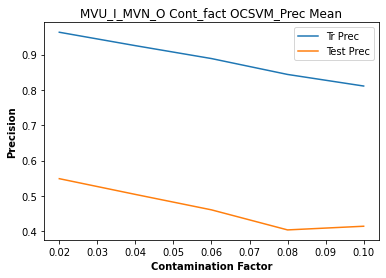

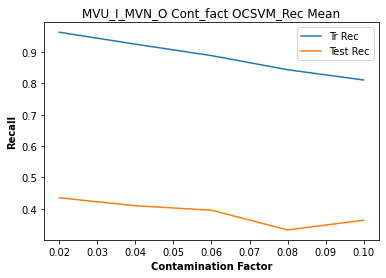

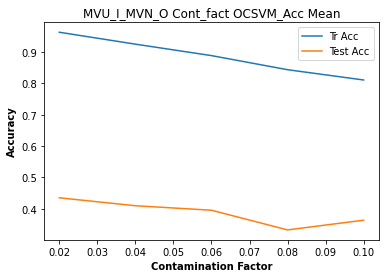

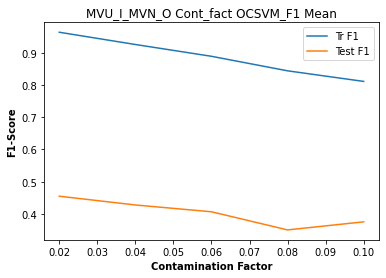

In [463]:
plt.title("MVU_I_MVN_O Cont_fact OCSVM_Prec Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'], ocsvm_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('MVU_I_MVN_O_OCSVM_CF_Mean_Prec.png', bbox_inches='tight')
plt.show()

plt.title("MVU_I_MVN_O Cont_fact OCSVM_Rec Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('MVU_I_MVN_O_Norm_I_Uni_O_OCSVM_CF_Mean_Rec.png', bbox_inches='tight')
plt.show()


plt.title("MVU_I_MVN_O Cont_fact OCSVM_Acc Mean")
plt.plot( ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('MVU_I_MVN_O_OCSVM_CF_Mean_Acc.png', bbox_inches='tight')
plt.show()


plt.title("MVU_I_MVN_O Cont_fact OCSVM_F1 Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('MVU_I_MVN_O_OCSVM_CF_Mean_F1.png', bbox_inches='tight')
plt.show()

### 2.2 LOF

In [464]:
dict_eval = {}

In [465]:
for i in range(len(cont_factor)):
  clf = LOF(contamination = cont_factor[i]);
  key = df_names_list[i]
  df = copy.deepcopy(dict_df[key])
  lst_name = []
  print(i)
  for j in df:
    #print("i & j ", i,j)
    temp_lst = []
    #X = norm.rvs(loc=mu, scale=std,size=10000);
    #df = label_gaussian_outliers_new( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    lst_name.append(temp_lst)

  df_name = "Eval_LOF_"+str(round(i,3))
  dict_eval[df_name]= pd.DataFrame(lst_name, columns=col_list)


0
1
2
3
4


In [466]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
lof_cont_results_mean = pd.DataFrame(columns = mu_result_cols) 
lof_cont_results_mean['cont_fact'] = cont_factor;
lst_mu = []

In [467]:
for val in dict_eval.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    
lof_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [468]:
lof_cont_results_mean
lof_cont_results_mean.to_excel("MVU_I_MVN_O_LOF_CF.xlsx");

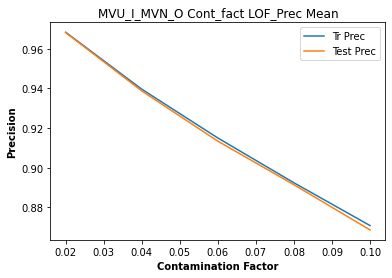

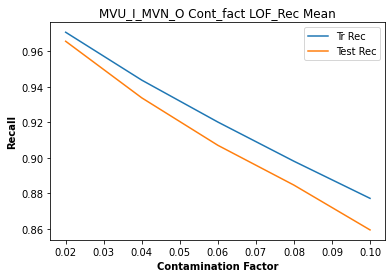

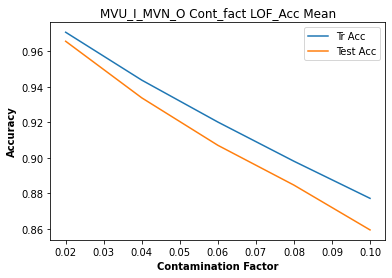

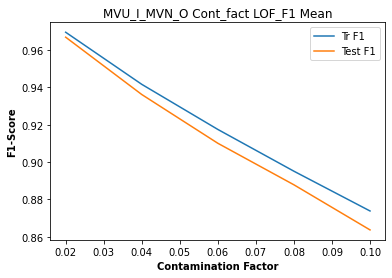

In [469]:
plt.title("MVU_I_MVN_O Cont_fact LOF_Prec Mean")
plt.plot(lof_cont_results_mean['cont_fact'], lof_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('MVU_I_MVN_O_LOF_CF_Mean_Prec.png', bbox_inches='tight')
plt.show()

plt.title("MVU_I_MVN_O Cont_fact LOF_Rec Mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('MVU_I_MVN_O_LOF_CF_Mean_Rec.png', bbox_inches='tight')
plt.show()


plt.title("MVU_I_MVN_O Cont_fact LOF_Acc Mean")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('MVU_I_MVN_O_LOF_CF_Mean_Acc.png', bbox_inches='tight')
plt.show()


plt.title("MVU_I_MVN_O Cont_fact LOF_F1 Mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('MVU_I_MVN_O_LOF_CF_Mean_F1.png', bbox_inches='tight')
plt.show()

### 2.3 PCA

In [470]:
dict_eval = {}

In [471]:
for i in range(len(cont_factor)):
  clf = PCA(contamination = cont_factor[i]);
  key = df_names_list[i]
  df = copy.deepcopy(dict_df[key])
  lst_name = []
  print(i)
  for j in df:
    #print("i & j ", i,j)
    temp_lst = []
    num_comp = int((len(j.columns)-1)/2);
    clf.n_components = num_comp;
    #X = norm.rvs(loc=mu, scale=std,size=10000);
    #df = label_gaussian_outliers_new( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    lst_name.append(temp_lst)

  df_name = "Eval_IF_"+str(round(i,3))
  dict_eval[df_name]= pd.DataFrame(lst_name, columns=col_list)


0
1
2
3
4


In [472]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
pca_cont_results_mean = pd.DataFrame(columns = mu_result_cols) 
pca_cont_results_mean['cont_fact'] = cont_factor;
lst_mu = []

In [473]:
for val in dict_eval.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    
pca_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [475]:
pca_cont_results_mean

,cont_fact,Train_Pr_mu,Test_Pr_mu,Train_Re_mu,Test_Re_mu,Train_Acc_mu,Test_Acc_mu,Train_F1_mu,Test_F1_mu
0,0.02,0.982071,0.981979,0.982071,0.981790,0.982071,0.981790,0.982071,0.981877
1,0.04,0.963040,0.963003,0.963040,0.963403,0.963040,0.963403,0.963040,0.963186
2,0.06,0.935589,0.935761,0.935589,0.935920,0.935589,0.935920,0.935589,0.935824
3,0.08,0.928000,0.927892,0.928000,0.928017,0.928000,0.928017,0.928000,0.927938
4,0.10,0.889543,0.889486,0.889543,0.889560,0.889543,0.889560,0.889543,0.889506


In [474]:

pca_cont_results_mean.to_excel("MVU_I_MVN_O_PCA_CF.xlsx");

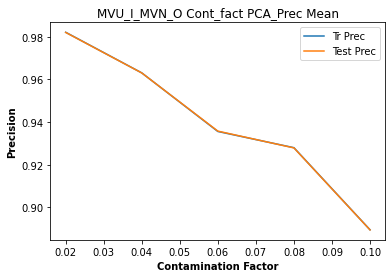

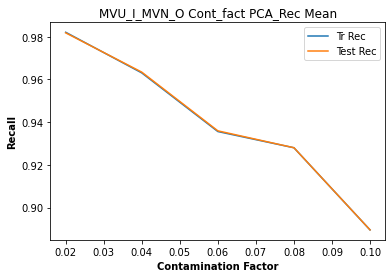

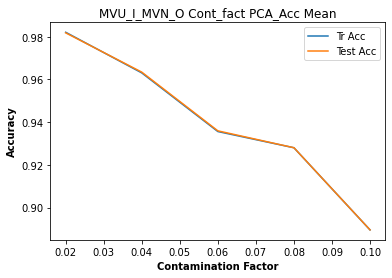

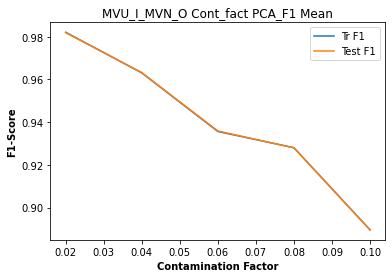

In [476]:
plt.title("MVU_I_MVN_O Cont_fact PCA_Prec Mean")
plt.plot(pca_cont_results_mean['cont_fact'], pca_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( pca_cont_results_mean['cont_fact'],pca_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('MVU_I_MVN_O_PCA_CF_Mean_PCA.png', bbox_inches='tight')
plt.show()

plt.title("MVU_I_MVN_O Cont_fact PCA_Rec Mean")
plt.plot(pca_cont_results_mean['cont_fact'],pca_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(pca_cont_results_mean['cont_fact'],pca_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('MVU_I_MVN_O_PCA_CF_Mean_Rec.png', bbox_inches='tight')
plt.show()


plt.title("MVU_I_MVN_O Cont_fact PCA_Acc Mean")
plt.plot( pca_cont_results_mean['cont_fact'],pca_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(pca_cont_results_mean['cont_fact'],pca_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('MVU_I_MVN_O_PCA_CF_Mean_Acc.png', bbox_inches='tight')
plt.show()


plt.title("MVU_I_MVN_O Cont_fact PCA_F1 Mean")
plt.plot(pca_cont_results_mean['cont_fact'],pca_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(pca_cont_results_mean['cont_fact'],pca_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('MVU_I_MVN_O_PCA_CF_Mean_F1.png', bbox_inches='tight')
plt.show()

### 2.4 IF

In [477]:
dict_eval = {}

In [478]:
for i in range(len(cont_factor)):
  clf = IForest(contamination = cont_factor[i], n_jobs = 100);
  key = df_names_list[i]
  df = copy.deepcopy(dict_df[key])
  lst_name = []
  print(i)
  for j in df:
    #print("i & j ", i,j)
    temp_lst = []
    num_comp = int((len(j.columns)-1)/2);
    clf.n_components = num_comp;
    #X = norm.rvs(loc=mu, scale=std,size=10000);
    #df = label_gaussian_outliers_new( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    lst_name.append(temp_lst)

  df_name = "Eval_IF_"+str(round(i,3))
  dict_eval[df_name]= pd.DataFrame(lst_name, columns=col_list)


0
1
2
3
4


In [479]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
if_cont_results_mean = pd.DataFrame(columns = mu_result_cols) 
if_cont_results_mean['cont_fact'] = cont_factor;
lst_mu = []

In [480]:
for val in dict_eval.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    
if_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [481]:
if_cont_results_mean
if_cont_results_mean.to_excel("MVU_I_MVN_O_CF_IF.xlsx");

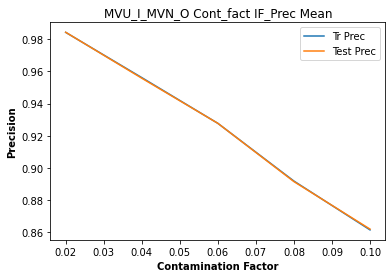

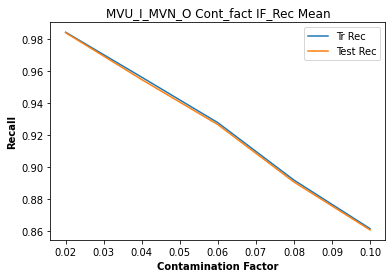

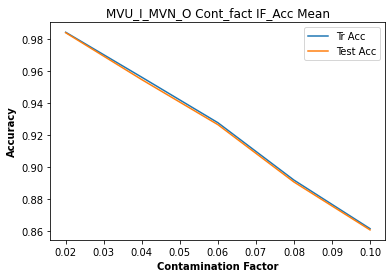

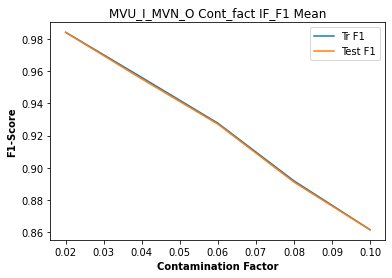

In [482]:
plt.title("MVU_I_MVN_O Cont_fact IF_Prec Mean")
plt.plot(if_cont_results_mean['cont_fact'], if_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( if_cont_results_mean['cont_fact'],if_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('MVU_I_MVN_O_CF_IF_Mean_Prec.png', bbox_inches='tight')
plt.show()

plt.title("MVU_I_MVN_O Cont_fact IF_Rec Mean")
plt.plot(if_cont_results_mean['cont_fact'],if_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(if_cont_results_mean['cont_fact'],if_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('MVU_I_MVN_O_CF_IF_Mean_Rec.png', bbox_inches='tight')
plt.show()


plt.title("MVU_I_MVN_O Cont_fact IF_Acc Mean")
plt.plot( if_cont_results_mean['cont_fact'],if_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(if_cont_results_mean['cont_fact'],if_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('MVU_I_MVN_O_CF_IF_Mean_Acc.png', bbox_inches='tight')
plt.show()


plt.title("MVU_I_MVN_O Cont_fact IF_F1 Mean")
plt.plot(if_cont_results_mean['cont_fact'],if_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(if_cont_results_mean['cont_fact'],if_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('MVU_I_MVN_O_CF_IF_Mean_F1.png', bbox_inches='tight')
plt.show()